In [ ]:
# ==============================================================
# 0. IMPORTS (CPU ONLY – NO GPU REQUIRED)
# ==============================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())  # OK if False

# ==============================================================
# 1. LOAD CSV
# ==============================================================
file_path = "imu_data.csv"
N_ROWS_TO_USE = 10000

df = pd.read_csv(file_path, nrows=N_ROWS_TO_USE)
print("Loaded:", df.shape)

df.columns = [
    'time',
    'accel_x','accel_y','accel_z',
    'gyro_x','gyro_y','gyro_z',
    'mag_x','mag_y','mag_z',
    'pos_x','pos_y','pos_z',
    'roll','pitch','yaw'
]

# ==============================================================
# 2. FEATURES / TARGETS
# ==============================================================
feature_cols = [
    'accel_x','accel_y','accel_z',
    'gyro_x','gyro_y','gyro_z',
    'mag_x','mag_y','mag_z'
]

target_cols = [
    'pos_x','pos_y','pos_z',
    'accel_x','accel_y','accel_z',
    'roll','pitch','yaw'
]

X_raw = df[feature_cols].values
y_raw = df[target_cols].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(X_raw)
y = scaler_y.fit_transform(y_raw)

# ==============================================================
# 3. CREATE SEQUENCES
# ==============================================================
seq_length = 10

def make_seq(X, y, L):
    xs, ys = [], []
    for i in range(len(X) - L):
        xs.append(X[i:i+L])
        ys.append(y[i+L])
    return np.array(xs), np.array(ys)

X_seq, y_seq = make_seq(X, y, seq_length)

split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32)

train_loader = DataLoader(
    list(zip(X_train, y_train)),
    batch_size=64,
    shuffle=True
)

# ==============================================================
# 4. MODEL
# ==============================================================
class FastLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(9, 64, num_layers=2, batch_first=True)
        self.fc   = nn.Linear(64, 9)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])

model = FastLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ==============================================================
# 5. TRAIN
# ==============================================================
print("\nTraining...")
for epoch in range(15):
    total = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"Epoch {epoch+1}/15 | Loss {total/len(train_loader):.6f}")

# ==============================================================
# 6. EVALUATION
# ==============================================================
model.eval()
with torch.no_grad():
    pred = model(X_test).numpy()
    true = y_test.numpy()

pred_inv = scaler_y.inverse_transform(pred)
true_inv = scaler_y.inverse_transform(true)

rmse = np.sqrt(mean_squared_error(true_inv, pred_inv))
mae  = mean_absolute_error(true_inv, pred_inv)
r2   = r2_score(true_inv, pred_inv)

print("\nMetrics:")
print("RMSE:", rmse)
print("MAE :", mae)
print("R2  :", r2)

# ==============================================================
# 7. SAVE PICKLE BUNDLE (FOR STREAMLIT)
# ==============================================================
bundle = {
    "model_state": model.state_dict(),
    "scaler_X": scaler_X,
    "scaler_y": scaler_y,
    "seq_length": seq_length,
    "feature_cols": feature_cols,
    "target_cols": target_cols
}

with open("uav_model_bundle.pkl", "wb") as f:
    pickle.dump(bundle, f)

print("Saved: uav_model_bundle.pkl")

# ==============================================================
# 8. EXPORT ONNX (CPU)
# ==============================================================
dummy = torch.randn(1, seq_length, 9)

torch.onnx.export(
    model,
    dummy,
    "uav_model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}},
    opset_version=12
)

print("Saved: uav_model.onnx")


Torch version: 2.9.0+cpu
CUDA available: False
Loaded: (10000, 16)

Training...
Epoch 1/15 | Loss 0.051157
Epoch 2/15 | Loss 0.023950
Epoch 3/15 | Loss 0.013880
Epoch 4/15 | Loss 0.010693
Epoch 5/15 | Loss 0.009110
Epoch 6/15 | Loss 0.008327
Epoch 7/15 | Loss 0.007459
Epoch 8/15 | Loss 0.006660
Epoch 9/15 | Loss 0.005935
Epoch 10/15 | Loss 0.005229
Epoch 11/15 | Loss 0.004577
Epoch 12/15 | Loss 0.004200
Epoch 13/15 | Loss 0.004040
Epoch 14/15 | Loss 0.003591


/tmp/ipython-input-3871571422.py:160: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0107 10:13:26.280000 1017 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 12 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


Epoch 15/15 | Loss 0.003363

Metrics:
RMSE: 11.005650889496033
MAE : 5.758799076080322
R2  : 0.01746683567762375
Saved: uav_model_bundle.pkl
[torch.onnx] Obtain model graph for `FastLSTM([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `FastLSTM([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/BaseConverter.h:68: adapter_lookup: Assertion `false`

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 2 of general pattern rewrite rules.
Saved: uav_model.onnx



Overall Accuracy (±0.05): 26.62%

Per-output Accuracy:
   pos_x Accuracy: 0.00%
   pos_y Accuracy: 0.15%
   pos_z Accuracy: 0.85%
 accel_x Accuracy: 1.05%
 accel_y Accuracy: 1.00%
 accel_z Accuracy: 2.70%
    roll Accuracy: 100.00%
   pitch Accuracy: 33.78%
     yaw Accuracy: 100.00%

Sequence Accuracy: 0.00%


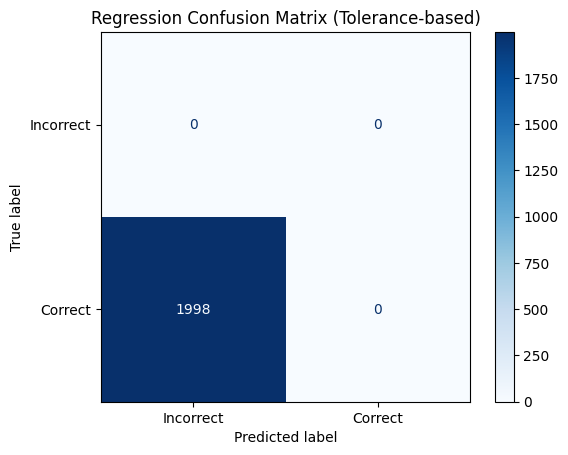

Epoch 1/15 | Loss 0.004536
Epoch 2/15 | Loss 0.004114
Epoch 3/15 | Loss 0.004107
Epoch 4/15 | Loss 0.003437
Epoch 5/15 | Loss 0.003434
Epoch 6/15 | Loss 0.003124
Epoch 7/15 | Loss 0.003056
Epoch 8/15 | Loss 0.002390
Epoch 9/15 | Loss 0.002322
Epoch 10/15 | Loss 0.002254
Epoch 11/15 | Loss 0.002251
Epoch 12/15 | Loss 0.002260
Epoch 13/15 | Loss 0.002137
Epoch 14/15 | Loss 0.001465
Epoch 15/15 | Loss 0.001493


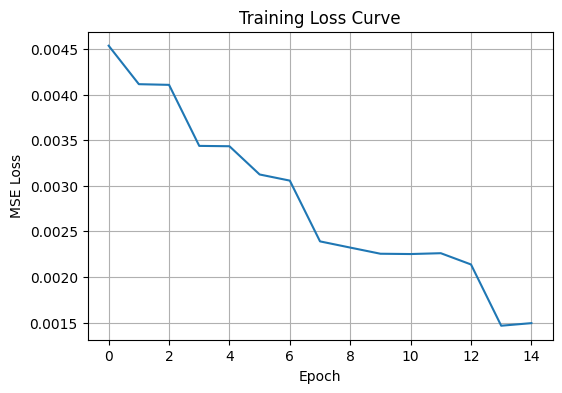

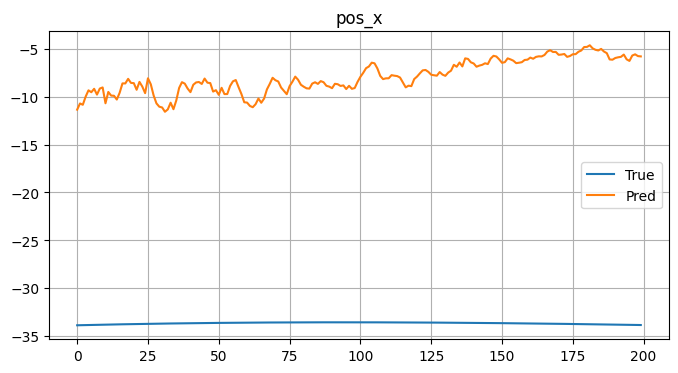

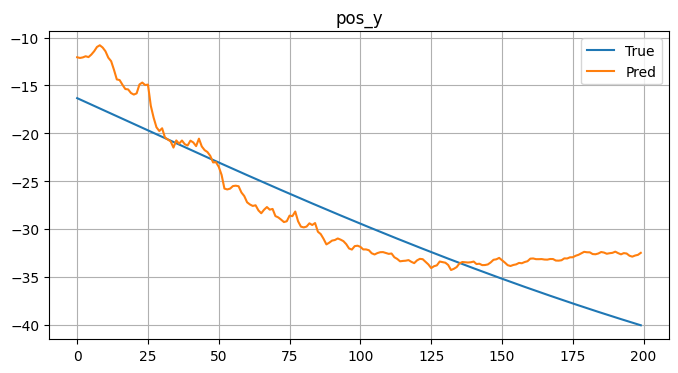

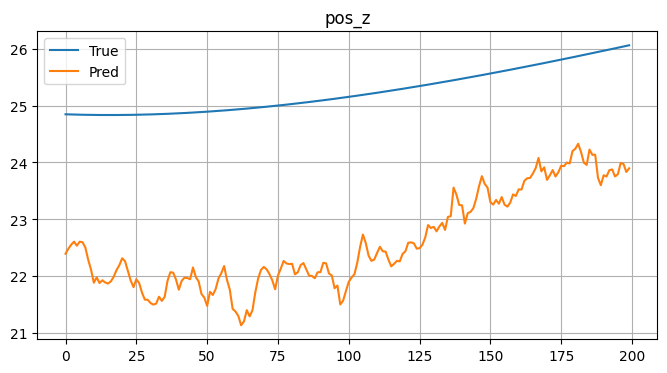

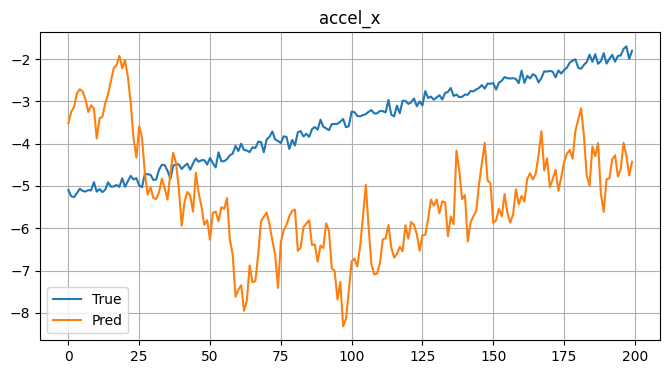

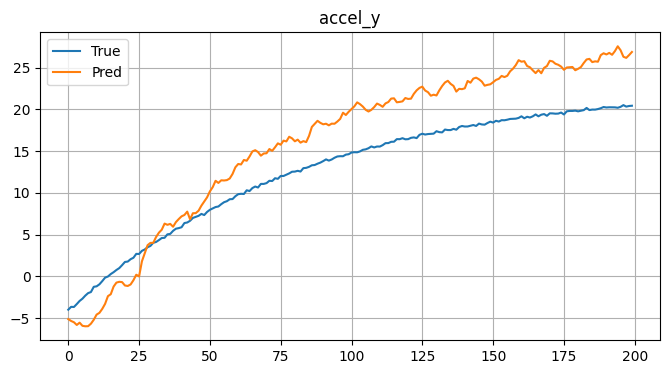

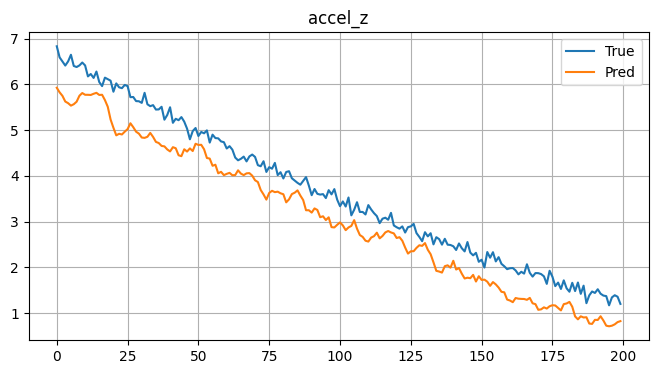

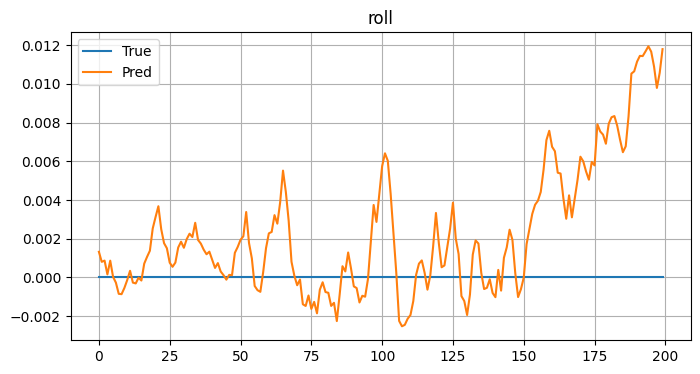

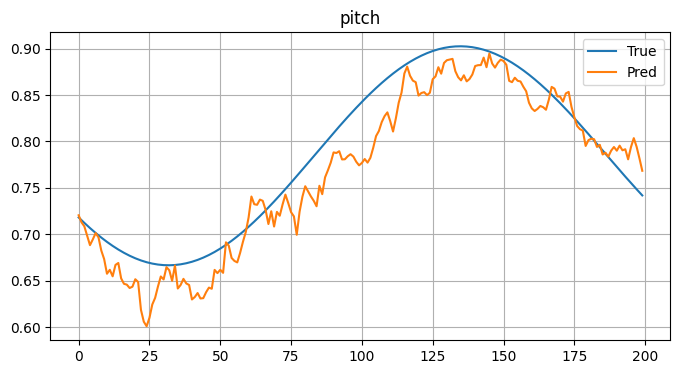

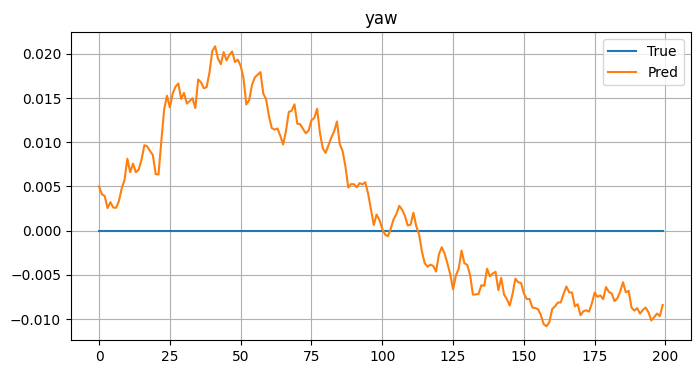

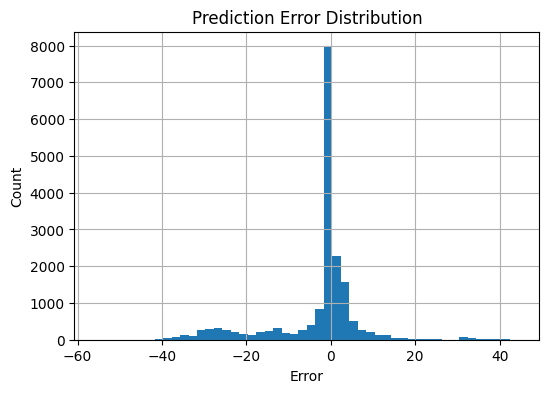

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ==============================================================
# 1. REGRESSION ACCURACY (TOLERANCE-BASED)
# ==============================================================
def regression_accuracy(y_true, y_pred, tolerance):
    return (np.abs(y_true - y_pred) <= tolerance).mean() * 100

tolerance = 0.05  # adjust based on your data scale

overall_acc = regression_accuracy(true_inv, pred_inv, tolerance)
print(f"\nOverall Accuracy (±{tolerance}): {overall_acc:.2f}%")

print("\nPer-output Accuracy:")
for i, col in enumerate(target_cols):
    acc = regression_accuracy(
        true_inv[:, i],
        pred_inv[:, i],
        tolerance
    )
    print(f"{col:>8s} Accuracy: {acc:.2f}%")

# ==============================================================
# 2. SEQUENCE-LEVEL ACCURACY (STRICT)
# ==============================================================
seq_correct = np.all(
    np.abs(true_inv - pred_inv) <= tolerance,
    axis=1
)
seq_accuracy = seq_correct.mean() * 100
print(f"\nSequence Accuracy: {seq_accuracy:.2f}%")

# ==============================================================
# 3. CONFUSION MATRIX (REGRESSION-CORRECT)
# ==============================================================
y_true_cls = np.ones(len(seq_correct))     # expected: correct
y_pred_cls = seq_correct.astype(int)       # model outcome

cm = confusion_matrix(y_true_cls, y_pred_cls)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Incorrect", "Correct"]
)
disp.plot(cmap="Blues")
plt.title("Regression Confusion Matrix (Tolerance-based)")
plt.grid(False)
plt.show()

# ==============================================================
# 4. TRAINING LOSS CURVE
# ==============================================================
loss_history = []

for epoch in range(15):
    total = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total += loss.item()

    avg_loss = total / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/15 | Loss {avg_loss:.6f}")

plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

# ==============================================================
# 5. PREDICTION vs GROUND TRUTH
# ==============================================================
def plot_prediction(idx, name, n=200):
    plt.figure(figsize=(8,4))
    plt.plot(true_inv[:n, idx], label="True")
    plt.plot(pred_inv[:n, idx], label="Pred")
    plt.title(name)
    plt.legend()
    plt.grid(True)
    plt.show()

for i, col in enumerate(target_cols):
    plot_prediction(i, col)

# ==============================================================
# 6. ERROR DISTRIBUTION
# ==============================================================
errors = true_inv - pred_inv

plt.figure(figsize=(6,4))
plt.hist(errors.flatten(), bins=50)
plt.title("Prediction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid(True)
plt.show()
